In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd
import pickle

In [4]:
from fastai.callbacks.csv_logger import CSVLogger

In [5]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [6]:
slides_train = list(set(['BAL Promyk Spray 4.svs',
                         'BAL AIA Blickfang Luft.svs']))

slides_val = list(set(['BAL 1 Spray 2.svs', 
                         'BAL Booker Spray 3.svs',
                         'BAL Bubi Spray 1.svs', 
                         'BAL cent blue Luft 2.svs']))

labels = ['Mastzellen', "Makrophagen", "Neutrophile", "Eosinophile", "Lymohozyten"]

In [7]:
experiment_name = "Asthma-L0-Screening-RN34"

In [8]:
annotations_path = Path("../Statistics/Asthma_Annotations.pkl")
annotations = pd.read_pickle(annotations_path)

annotations = annotations[annotations["class"].isin(labels)]
annotations_train = annotations[annotations["image_name"].isin(slides_train)]
annotations_val = annotations[annotations["image_name"].isin(slides_val)]
annotations_train.head()

id  image_id              image_name  image_set        class  \
21105  140917       226  BAL Promyk Spray 4.svs         14  Makrophagen   
21106  140918       226  BAL Promyk Spray 4.svs         14  Makrophagen   
21107  140919       226  BAL Promyk Spray 4.svs         14  Makrophagen   
21108  140920       226  BAL Promyk Spray 4.svs         14  Makrophagen   
21109  140921       226  BAL Promyk Spray 4.svs         14  Makrophagen   

                                                  vector  \
21105  {'x1': 14371, 'x2': 14435, 'y1': 14738, 'y2': ...   
21106  {'x1': 14066, 'x2': 14152, 'y1': 14692, 'y2': ...   
21107  {'x1': 14377, 'x2': 14451, 'y1': 14646, 'y2': ...   
21108  {'x1': 14304, 'x2': 14384, 'y1': 14600, 'y2': ...   
21109  {'x1': 14318, 'x2': 14402, 'y1': 14544, 'y2': ...   

                          unique_identifier  user_id  deleted last_editor  
21105  2c2f610e-f4f7-4e05-8236-ffa28418550d       10    False        None  
21106  bcf159fc-2a41-4a69-a4cd-9b48da8fc663       10    False        None  
21107  f5e247d5-9c38-4e22-9329-56805024cf83       10    False        None  
21108  f68910d0-eb8f-4715-ad8d-accd060efff1       10    False        None  
21109  013f3fc1-b603-41ce-8357-e446db2c9a14       10    False        None

In [9]:
annotations["width"] = [vector["x2"] - vector["x1"] for vector in annotations["vector"]]
annotations["height"] = [vector["y2"] - vector["y1"] for vector in annotations["vector"]]
annotations["scale"] = annotations["width"] / annotations["height"]

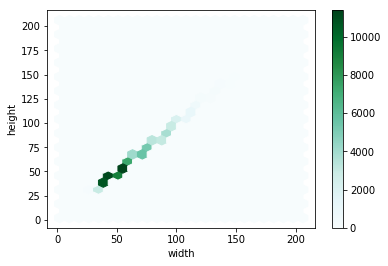

In [10]:
annotations.plot.hexbin(x='width', y='height', gridsize=25) #C='scale', 

In [11]:
slides_path = Path("../Slides")
files = {slide.name: slide for slide in slides_path.rglob("*.svs") if slide.name in slides_train + slides_val}
files

{'BAL 1 Spray 2.svs': PosixPath('../Slides/BAL 1 Spray 2.svs'),
 'BAL AIA Blickfang Luft.svs': PosixPath('../Slides/BAL AIA Blickfang Luft.svs'),
 'BAL Booker Spray 3.svs': PosixPath('../Slides/BAL Booker Spray 3.svs'),
 'BAL Bubi Spray 1.svs': PosixPath('../Slides/BAL Bubi Spray 1.svs'),
 'BAL Promyk Spray 4.svs': PosixPath('../Slides/BAL Promyk Spray 4.svs'),
 'BAL cent blue Luft 2.svs': PosixPath('../Slides/BAL cent blue Luft 2.svs')}

In [12]:
with open('../Statistics/Screening.pickle', 'rb') as handle:
    screening_modes = pickle.load(handle)

In [13]:
def filterAnnotations(image_name, xmin, ymin, screening_modes, patch_x:int = 1024, patch_y:int = 1024):
    
    screening = screening_modes[image_name]
    tiles = screening["screening_tiles"]  
    
    xmin, ymin = max(1, int(xmin - patch_x / 2)), max(1, int(ymin - patch_y / 2))
    
    x_step = int(np.ceil(xmin / screening["x_resolution"]))
    y_step = int(np.ceil(ymin / screening["y_resolution"]))
    
    return tiles[str((y_step * screening["x_steps"]) + x_step)]['Screened']

In [14]:
annotations_train["border"] = annotations_train.apply(lambda x: filterAnnotations(x["image_name"], x["vector"]["x1"], x["vector"]["y1"], screening_modes), axis=1)
annotations_val["border"] = annotations_val.apply(lambda x: filterAnnotations(x["image_name"], x["vector"]["x1"], x["vector"]["y1"], screening_modes), axis=1)
annotations_val.head()

/home/c.marzahl@de.eu.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/c.marzahl@de.eu.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


id  image_id         image_name  image_set        class  \
0  172441       221  BAL 1 Spray 2.svs         14  Makrophagen   
1  172442       221  BAL 1 Spray 2.svs         14  Makrophagen   
2  172443       221  BAL 1 Spray 2.svs         14  Makrophagen   
3  172444       221  BAL 1 Spray 2.svs         14  Makrophagen   
4  172446       221  BAL 1 Spray 2.svs         14  Makrophagen   

                                              vector  \
0  {'x1': 13612, 'x2': 13666, 'y1': 12371, 'y2': ...   
1  {'x1': 13562, 'x2': 13618, 'y1': 12437, 'y2': ...   
2  {'x1': 13482, 'x2': 13546, 'y1': 12458, 'y2': ...   
3  {'x1': 13471, 'x2': 13533, 'y1': 12281, 'y2': ...   
4  {'x1': 13591, 'x2': 13673, 'y1': 12204, 'y2': ...   

                      unique_identifier  user_id  deleted last_editor  border  
0  a268b46f-e13f-480e-b96d-c7900790ad5f       10    False        None   False  
1  e8d67efd-0baf-4f78-ad73-b8f77422b826       10    False        None   False  
2  55aa3d51-7f30-43a0-83ef-d9acc74d9a21       10    False        None   False  
3  8f259e8f-119b-44de-8a90-2c53e7ee0e60       10    False        None   False  
4  052b3f5a-f6f6-4b0d-a134-9f4797601dc4       10    False        None   False

In [15]:
class SlideContainerWithScreening(SlideContainer):

    def get_new_train_coordinates(self):
        # use passed sampling method
        if callable(self.sample_func):
            return self.sample_func(self.y, **{"classes": self.classes, "size": self.shape,
                                               "level_dimensions": self.slide.level_dimensions,
                                               "level": self.level})

        # use default sampling method
        width, height = self.slide.level_dimensions[self.level]
        if len(self.y[0]) == 0:
            return randint(0, width - self.shape[0]), randint(0, height - self.shape[1])
        else:
            # use default sampling method
            class_id = np.random.choice( self.classes, 1)[0]
            ids = (np.array(self.y[1]) == class_id) & (np.array(self.y[2]) == True)
            #  if you can´t fond any ignore screened area
            if np.count_nonzero(ids) == 0:
                ids = (np.array(self.y[1]) == class_id)
            xmin, ymin, _, _ = np.array( self.y[0])[ids][randint(0, np.count_nonzero(ids) - 1)]

            xmin, ymin = max(1, int(xmin - self.shape[0] / 2)), max(1, int(ymin - self.shape[1] / 2))
            xmin, ymin = min(xmin, width - self.shape[0]), min(ymin, height - self.shape[1])

            return xmin, ymin

In [16]:
size = 1024 
level = 0
bs = 8
train_images = 500
val_images = 500

In [17]:
train_files = []
val_files = []

In [18]:
for image_name in annotations_train["image_name"].unique():
    
    annotations = annotations_train[annotations_train["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["class"])
    borders = list(annotations["border"])
    
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    for label in labels:
        if label not in set(labels):
            bboxes.append([0,0,0,0])
            labels.append(label)
            borders.append(True)

    train_files.append(SlideContainerWithScreening(slide_path, y=[bboxes, labels, borders],  level=level, width=size, height=size))
    
for image_name in annotations_val["image_name"].unique():
    
    annotations = annotations_val[annotations_val["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["class"])
    borders = list(annotations["border"])
    
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    for label in labels:
        if label not in set(labels):
            bboxes.append([0,0,0,0])
            labels.append(label)
            borders.append(True)

    val_files.append(SlideContainerWithScreening(slide_path, y=[bboxes, labels, borders],  level=level, width=size, height=size))

train_files = list(np.random.choice(train_files, train_images))
valid_files = list(np.random.choice(val_files, val_images))

In [19]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      #max_lighting=0.0,
                      #max_zoom=1.,
                      #max_warp=0.0,
                      #p_affine=0.5,
                      #p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

In [20]:
def get_y_func(x):
    return x.y

In [21]:
train =  ObjectItemListSlide(train_files, path=slides_path)
valid = ObjectItemListSlide(valid_files, path=slides_path)
item_list = ItemLists(slides_path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate).normalize() #, num_workers=0

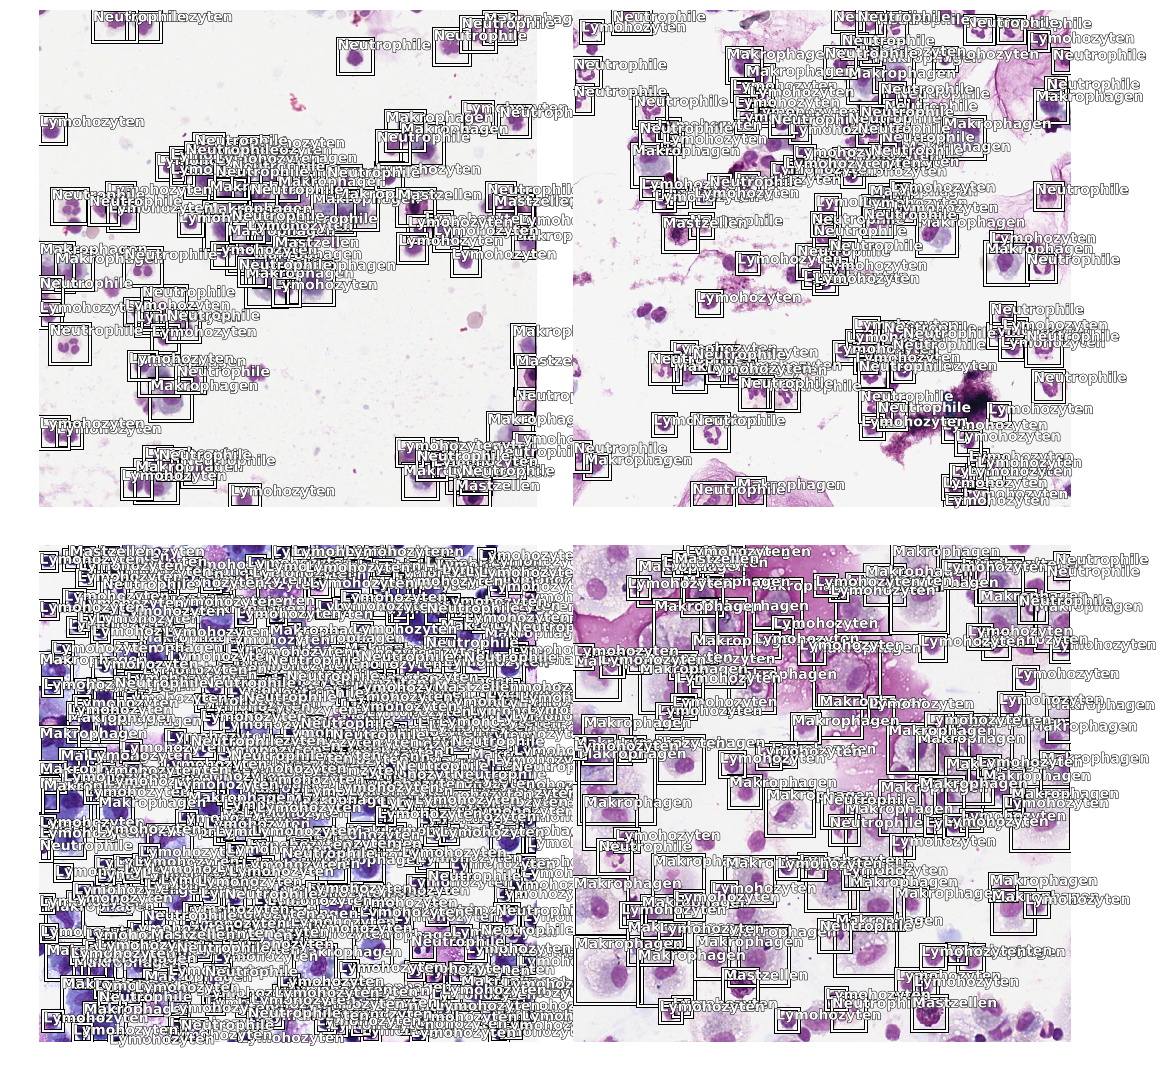

In [22]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))

In [23]:
scales = [.8, .9, 1, 1.1]
anchors = create_anchors(sizes=[(64, 64), (32,32)], ratios=[1], scales=scales)

In [24]:
crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet50, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=len(scales), sizes=[64, 32], chs=128, final_bias=-4., n_conv=2)

In [25]:
data.train_ds.y.classes[1:]

['Eosinophile', 'Lymohozyten', 'Makrophagen', 'Mastzellen', 'Neutrophile']

In [26]:
voc = PascalVOCMetricByDistance(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]], radius=40)
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics], #BBMetrics, ShowGraph
                metrics=[voc])

In [27]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [28]:
learn.fit_one_cycle(3, 1e-3)

In [29]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

In [30]:
learn.fit_one_cycle(10, 1e-3)

In [31]:
learn.fit_one_cycle(10, 1e-3)

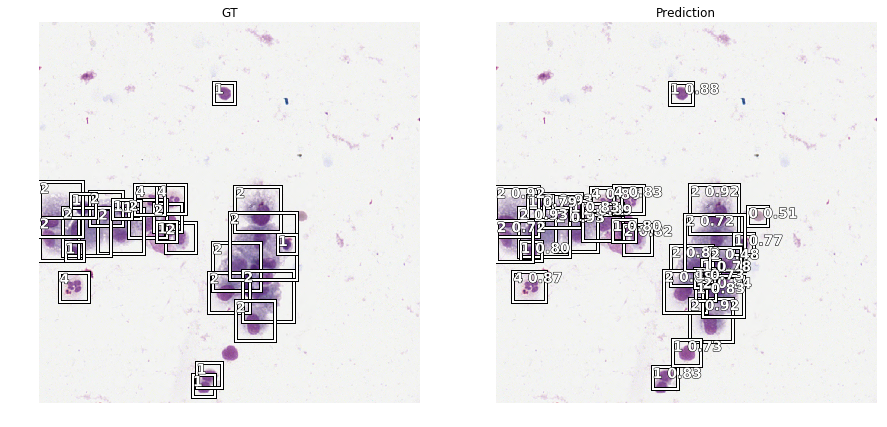

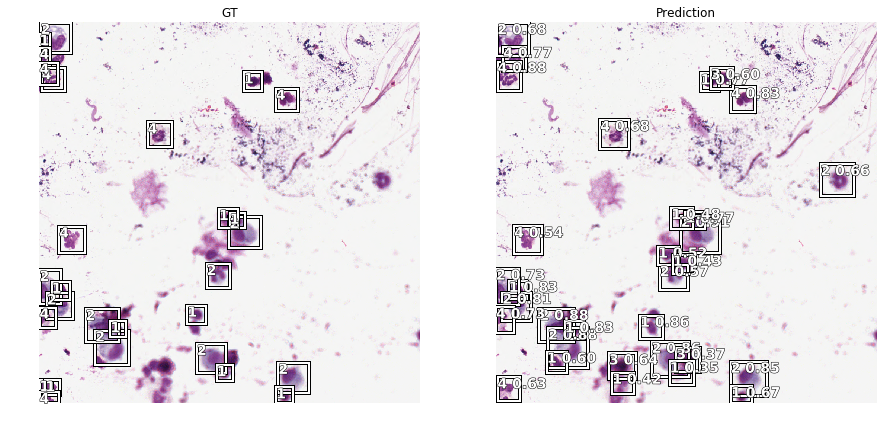

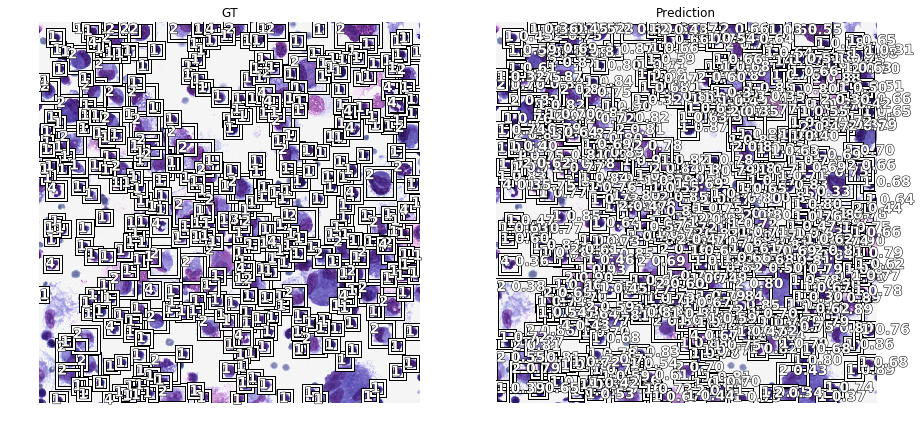

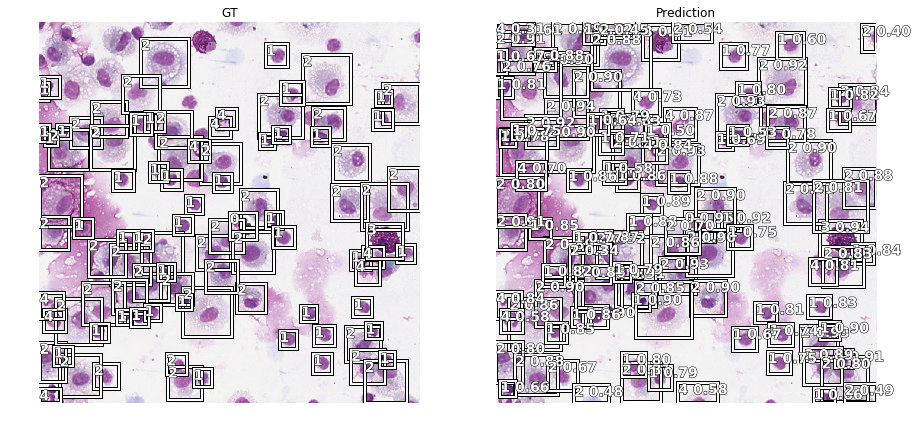

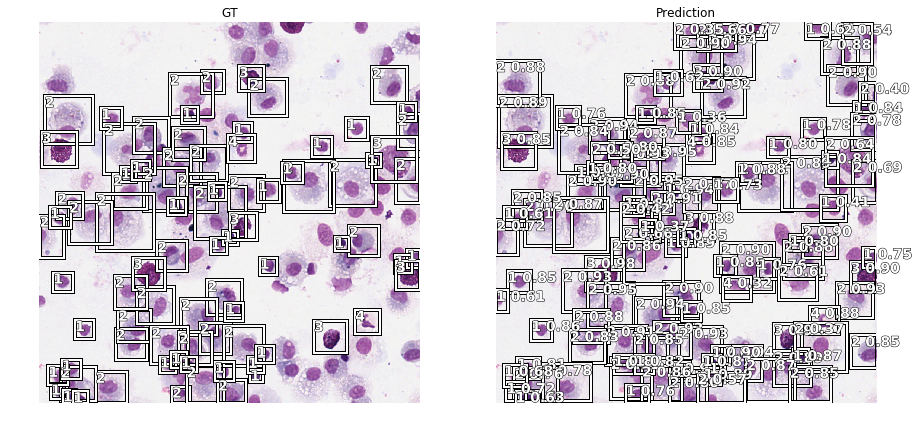

In [32]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2)

In [33]:
data.c

6

In [34]:
import pickle

stats = {"anchors": anchors,
         "mean": to_np(data.stats[0]),
         "std": to_np(data.stats[1]),
         "size": size,
         "n_classes": data.c,
         "n_anchors": len(scales),
         "sizes": [64, 32],
         "chs": 128,
         "encoder": "RN-34",
         "n_conv": 2,
         "level": 0,
         "model": get_model(learn.model).state_dict()
        }

torch.save(stats, "{}.p".format(experiment_name))